# Demodulacija MFSK -- v1

### biblioteke

In [12]:
import numpy as np
import fastgoertzel as G
from scipy.io import wavfile
from ipyfilechooser import FileChooser
import matplotlib.pyplot as plt
import os
from pathlib import Path
from os.path import exists
# import librosa
import scipy.fft as fft
import scipy
from scipy.signal import remez,freqz,firwin
import decimal
from scipy.signal import find_peaks
# from scipy.signal import findfre2
import binascii

In [2]:
%matplotlib widget
#%matplotlib notebook

### selektor i ucitavanje fajla

In [3]:

def biraj_folder() -> FileChooser:
    # biranje foldera
    fc = FileChooser()
    fc.show_only_dirs = True

    # brza pretraga da nadje default folder, sto da ne
    for dirname,_,_ in os.walk(fc.default_path):
        if Path(dirname).name == "wav":
            fc.default_path = dirname
            fc._select_default = True  ## da ne moramo da selektujemo svaki put
            fc.reset()
            break
    # ovo valjda odradi posao
    display(fc)
    return fc

def ucitaj_fajl(fc:FileChooser):
    global samplerate, sig
    # zapravo ucitavanje fajla ## mozda bi valjalo da resimo da se radi kroz neki update automatski kad selektujes
    selected = os.fsencode(fc.selected)
    # filename = os.fsdecode(file)

    if os.path.isfile(selected):
        try:
            # sig, samplerate = librosa.load(fc.selected + filename) 
            samplerate, sig = wavfile.read(fc.selected) 

        except:
            print("greska sa citanjem fajla:" + fc.selected)


def biraj_fajl():
    # biranje fajla
    fc = FileChooser()
    fc.register_callback(ucitaj_fajl)
    display(fc)
    # return fc

In [4]:
biraj_fajl()

FileChooser(path='/home/zarko/PFE/LK_S_2024/skriveni-kanali', filename='', title='', show_hidden=False, select…

### sanity check spektogram fajla

/home/zarko/.local/lib/python3.9/site-packages/matplotlib/axes/_axes.py:8089: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


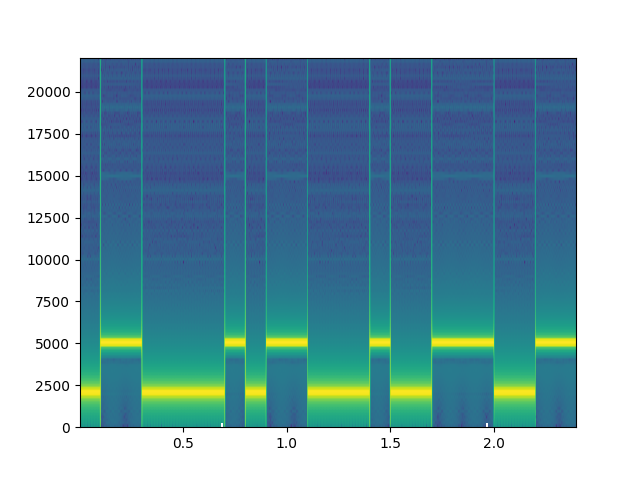

In [5]:
plt.specgram(sig,Fs = samplerate)
plt.show()

### bandpass filter testing -- incomplete

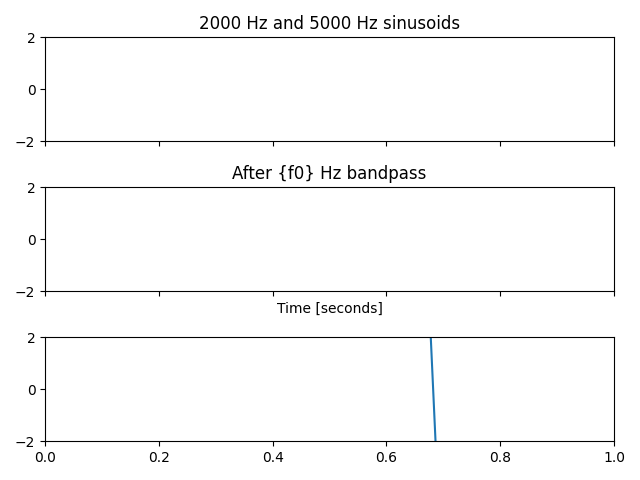

In [7]:
samplerate=44100

t = np.linspace(0,len(sig/samplerate),len(sig))
fig, (ax1, ax2,ax3) = plt.subplots(3, 1, sharex=True)

ax1.plot(t, sig)

f0 = 2000
f1 = 5000
ax1.set_title(f'{f0} Hz and {f1} Hz sinusoids')
ax1.axis([0, 1, -2, 2])

sos = scipy.signal.butter(3,[f0 - 200,f0 + 200],fs=samplerate,btype="band",output="sos")
# w,h = scipy.signal.freqs(b,a)
filtered_signal =scipy.signal.sosfiltfilt(sos,sig)
ax2.plot(t, filtered_signal)
ax2.set_title('After {f0} Hz bandpass')

ax2.axis([0, 1, -2, 2])

ax2.set_xlabel('Time [seconds]')

sos2 = scipy.signal.butter(3,[f1-200,f1+200],fs=samplerate,btype="band",output="sos")
filtered_signal2 =scipy.signal.sosfiltfilt(sos2,sig)
ax3.plot(t,filtered_signal2)
ax3.axis([0, 1, -2, 2])


plt.tight_layout()

plt.show()

In [9]:
# t = np.arange(len(sig) )/samplerate
plt.plot(t, filtered_signal)
# plt.plot(t,filtered_signal2)
# plt.plot(t,filtered_signal)

In [ ]:
from scipy.signal import butter, lfilter


def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(sig, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, sig)
    return y


if __name__ == "__main__":
    import numpy as np
    import matplotlib.pyplot as plt
    from scipy.signal import freqz

    # Sample rate and desired cutoff frequencies (in Hz).
    fs = 40000.0
    lowcut = 900.0
    highcut = 1100.0

    # Plot the frequency response for a few different orders.
    plt.figure(1)
    plt.clf()
    for order in [3, 6, 9]:
        b, a = butter_bandpass(lowcut, highcut, fs, order=order)
        w, h = freqz(b, a, worN=2000)
        plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

    plt.plot([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
             '--', label='sqrt(0.5)')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Gain')
    plt.grid(True)
    plt.legend(loc='best')

    # Filter a noisy signal.
    T = 1
    nsamples = T * fs
    t = np.linspace(0, T, int(nsamples), endpoint=False)
    a = 0.02
    f0 = 1000.0
    x = 0.1 * np.sin(2 * np.pi * 1.2 * np.sqrt(t))
    x += 0.01 * np.cos(2 * np.pi * 312 * t + 0.1)
    x += a * np.cos(2 * np.pi * f0 * t + .11)
    x += 0.03 * np.cos(2 * np.pi * 2000 * t)
    plt.figure(2)
    plt.clf()
    plt.plot(t, x, label='Noisy signal')

    y = butter_bandpass_filter(x, lowcut, highcut, fs, order=3)
    plt.plot(t, y, label='Filtered signal (%g Hz)' % f0)
    plt.xlabel('time (seconds)')
    plt.hlines([-a, a], 0, T, linestyles='--')
    plt.grid(True)
    plt.axis('tight')
    plt.legend(loc='upper left')

    plt.show() 

In [ ]:
# plt.plot(filtered_signal)
type(filtered_signal)
filtered_signal

### goertzel demod v1 -- incomplete, odd behaviour

In [ ]:
start_time = 0
end_time = 1
sample_rate = 44100
time = np.arange(start_time, end_time, 1/sample_rate)
theta = 0
frequency = 2000
amplitude = 1
sinewave = amplitude * np.sin(2 * np.pi * frequency * time + theta)
# figure(figsize=(20, 6), dpi=80)
# plt.plot(sinewave)


In [ ]:
sig = sig
dt = 0.1
f0 = 2000
f1 = 5000
a = []
b = []
small_segment = int(samplerate * dt  * 0.01)
small_segment = 50
for i in np.arange(0,len(sig)/samplerate,dt):
    amp1,_ = G.goertzel(sig[int(i*samplerate + small_segment):int((i+dt)*samplerate) - small_segment]/1,f0)
    
    # amp2,_ = G.goertzel(sig/1,f1)
    # print(amp)
    a.append(amp1)
    # b.append(amp2)

for i in np.arange(0,len(sig)/samplerate,dt):
    amp1,_ = G.goertzel(sig[int(i*samplerate + small_segment):int((i+dt)*samplerate) - small_segment]/1,f0)
    
    # amp2,_ = G.goertzel(sig/1,f1)
    # print(amp)
    b.append(amp2)
    amp2,_ = G.goertzel(sig[int(i*samplerate + small_segment):int((i+dt)*samplerate) - small_segment ]/1,f1)


In [ ]:
print(a)
print(b)
plt.plot(a)
plt.plot(b)
# plt.specgram(sig)
# plt.plot(np.array(a) - np.array(b))

In [ ]:
# fft sanity check
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack

# Number of samplepoints
N = len(sig)
# sample spacing
T = 1.0 / samplerate
x = np.linspace(0.0, N*T, N)
y = sig
# y = np.sin(50.0 * 2.0*np.pi*x) + 0.5*np.sin(80.0 * 2.0*np.pi*x)
yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

fig, ax = plt.subplots()
ax.plot(xf[:int(len(sig)/8)], 2.0/N * np.abs(yf[:N//8]))
plt.show()

## simple demodulation using FFT

In [15]:
class BitAppender:
    def __init__(self):
        self.buffer = bytearray()
        self.current_byte = 0
        self.bit_count = 0

    def append_bit(self, bit):
        if bit not in (0, 1):
            raise ValueError("Bit must be 0 or 1")

        # Add the bit to the current byte
        self.current_byte = (self.current_byte << 1) | bit
        self.bit_count += 1

        # If we have accumulated 8 bits, store the byte and reset
        if self.bit_count == 8:
            self.buffer.append(self.current_byte)
            self.current_byte = 0
            self.bit_count = 0

    def get_bytes(self):
        # If there are leftover bits, pad with zeros and add the final byte
        if self.bit_count > 0:
            self.current_byte <<= (8 - self.bit_count)
            self.buffer.append(self.current_byte)
        return bytes(self.buffer)

# Example usage:
bit_appender = BitAppender()
# bits = [1, 0, 1, 1, 0, 0, 1, 0,  # 0b10110010 (178 in decimal)
#         1, 1, 1, 1, 0, 0, 1, 1]  # 0b11110011 (243 in decimal)

# for bit in bits:
#     bit_appender.append_bit(bit)

# result = bit_appender.get_bytes()
# print(result)  # Output: b'\xb2\xf3'


In [18]:


dt = 0.1
f0 = 2000
f1 = 5000
bit_appender = BitAppender()


small_segment = int(samplerate * dt  * 0.01)
small_segment = 50 # mali delic tako da ne uhvatimo prelaze frekvencija i olaksamo potrebe sinhronizacije

# fft sanity check

N = len(sig)

T = 1.0 / samplerate
x = np.linspace(0.0, N*T, N)
y = sig

yf = scipy.fftpack.fft(y)
xf = np.linspace(0.0, 1.0/(2.0*T), N//2)

# fig, ax = plt.subplots()
# ax.plot(xf[:int(len(sig)/8)], 2.0/N * np.abs(yf[:N//8]))
# plt.show()

peak_tresh = 0.1

binlist = bytearray

for i in np.arange(0,len(sig)/samplerate,dt):
    y1 = sig[int(i*samplerate + small_segment):int((i+dt)*samplerate) - small_segment]/1
    y1fft = scipy.fft.rfft(y1)
    n = int((i+dt)*samplerate) - small_segment - int(i*samplerate + small_segment)
    n = int(dt * samplerate)- 2 * small_segment
    freqs = fft.rfftfreq(n,1./samplerate)
    peaks,props = find_peaks(y1fft,height = peak_tresh)
    for y in range(len(peaks)):
        if (1900 < freqs[peaks[y]]< 2100 ):      bit_appender.append_bit(0); break;
        if (4900 < freqs[peaks[y]]< 5100 ):      bit_appender.append_bit(1); break;
    # print(freqs[peaks])
    # x1fft = xf = np.linspace(0.0, 1.0/(2.0*T), N//2)
    # amp2,_ = G.goertzel(sig/1,f1)
    # print(amp)
    # a.append(amp1)
    # b.append(amp2)
# plt.plot(y1fft)
# plt.plot(peaks, y1fft[peaks])
# print(len(y1fft))
# for i in np.arange(0,len(sig)/samplerate,dt):
#     amp1,_ = G.goertzel(sig[int(i*samplerate + small_segment):int((i+dt)*samplerate) - small_segment]/1,f0)
    
#     # amp2,_ = G.goertzel(sig/1,f1)
#     # print(amp)
#     b.append(amp2)
#     amp2,_ = G.goertzel(sig[int(i*samplerate + small_segment):int((i+dt)*samplerate) - small_segment ]/1,f1)

result = bit_appender.get_bytes()
print(result)  # Output: b'\xb2\xf3'

b'mi slike pola 8'


In [ ]:
plt.plot(freqs, np.abs(y1fft), '-', freqs[peaks])

In [ ]:
print(freqs[peaks])